# Mapping data to the Human Lung Cell Atlas for joint analysis and cell type label transfer

In this tutorial we will show how to map single-cell data to a reference. Such mapping yields a joint embedding of the reference and the mapped ("query") data, which can be used for downstream analysis including clustering and trajectory analysis. Moreover, once the data is mapped, it is possible to perform label transfer from the reference to the query, thus providing a first annotation of all cells in the query data with minimial effort. We will use the [Human Lung Cell Atlas](https://github.com/LungCellAtlas/HLCA) as an example reference. We will furthermore use the scANVI model previously generated to integrate the datasets in the HLCA as our base reference model, on which we will perform scArches surgery to enable mapping and batch correction of the query dataset. Finally, we use a KNN classifier from scArches to perform cell type label transfer from the reference to the query.

As the HLCA was annotated at five different levels (coarse to fine annotations), we will also display five different levels of cell annotation and their uncertainties for our mapping.

The initial version of this notebook was compiled by Lisa Sikkema.

## Setup

### Import libraries and set figure parameters and paths

In [1]:
import os

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
import sys
import scanpy as sc
import numpy as np
import pandas as pd
import scarches as sca
import anndata as ad
from scipy import sparse
import gdown
import gzip
import shutil
import urllib.request

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_mapping_env_new/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:[rank: 0] Global seed set to 0


In [3]:
sca.__file__

'/lustre/groups/ml01/code/lisa.sikkema/scarches/scarches/__init__.py'

Set scanpy figure parameters:

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

Set paths:

In [5]:
ref_model_dir_prefix = "."  # directory in which to store the reference model directory
surgery_model_dir_prefix = (
    "."  # directory in which to store the surgery model directory
)
path_reference_emb = (
    "./HLCA_emb_and_metadata.h5ad"  # path to reference embedding to be created
)
path_query_data = "./HLCA_query.h5ad"  # input test query data
# don't change the following paths:
ref_model_dir = os.path.join(
    ref_model_dir_prefix, "HLCA_reference_model"
)  # don't change this
surgery_model_dir = os.path.join(
    surgery_model_dir_prefix, "surgery_model"
)  # don't change this

In [6]:
%load_ext lab_black

### Download reference data and reference model:

We will start with downloading the needed data. First, let's download the reference model, on which we will perform surgery. The HLCA reference model can be found on Zenodo, and we'll download it below:

TO DO: update to final HLCA model once uploaded to Zenodo

In [7]:
url = "https://zenodo.org/record/6337966/files/HLCA_reference_model.zip"
output = "HLCA_reference_model.zip"
gdown.download(url, output, quiet=False)
shutil.unpack_archive("HLCA_reference_model.zip", extract_dir=ref_model_dir_prefix)
os.remove(output)

Downloading...
From: https://zenodo.org/record/6337966/files/HLCA_reference_model.zip
To: /lustre/groups/ml01/code/lisa.sikkema/scarches/notebooks/HLCA_reference_model.zip
100%|██████████| 5.32M/5.32M [00:00<00:00, 5.41MB/s]


As the HLCA model was generated with an older version of scVI and is not compatible with the current scArches, we will first convert it to the newer model format:

In [8]:
sca.models.SCANVI.convert_legacy_save(
    dir_path=ref_model_dir, output_dir_path=ref_model_dir, overwrite=True
)

We will furthermore download the reference itself. As scArches allows the mapping of query data onto an existing reference *embedding*, we will only need to download the embedding of the HLCA reference. That saves a lot of time and memory compared to downloading the full count matrix.

TO DO: update to final HLCA embedding once uploaded to Zenodo

In [9]:
url = "https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad"
output = path_reference_emb
gdown.download(url, output, quiet=False)

Downloading...
From: https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad
To: /lustre/groups/ml01/code/lisa.sikkema/scarches/notebooks/HLCA_emb_and_metadata.h5ad
100%|██████████| 218M/218M [00:48<00:00, 4.46MB/s] 


'./HLCA_emb_and_metadata.h5ad'

Let's load our downloaded reference embedding:

In [10]:
adata_ref = sc.read_h5ad(path_reference_emb)

### Load query data and match feature naming with reference model:

Finally, we need to have query data which we want to map to the reference. For this tutorial, we will use an example [dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171668) from the [Delorey et al. publication](  https://www.nature.com/articles/s41586-021-03570-8.) as query dataset to map to the HLCA reference, but you can use your own data for this as well. For our example, we only use one sample  (the fresh single-cell sample) from the Delorey dataset. We already prepared an .h5ad file for that sample in this repository, so no need to download this file, we can just load it:

In [5]:
adata_query_unprep = sc.read_h5ad(path_query_data)

Now we prepare our query data, so that it includes the right genes (this depends on the genes used for the reference model, missing genes are padded with zeros) and has those genes in the right order. Preparing your query data ensures data corectness and smooth running of the scArches reference mapping.

Let's check if our reference model uses gene names or gene ids as input features. We will need to match our query data with the reference model.

In [6]:
ref_model_features = pd.read_csv(os.path.join(ref_model_dir, "var_names.csv"))

In [7]:
ref_model_features.head(5)

ENSG00000000938
0  ENSG00000000971
1  ENSG00000002587
2  ENSG00000002933
3  ENSG00000003436
4  ENSG00000004776

As you can see, the HLCA reference model requires ensemble IDs. Therefore, if your data includes ensembl IDs, we can proceed and use the standard scArches function to subset and pad our query AnnData. Make sure your `adata_query_unprep.var.index` contains the gene ids. If you instead only have gene names and no IDs for your query data, we will have to prepare your data manually (see below).

The test data already has ensembl ids as index:

In [8]:
adata_query_unprep.var.head(5)

gene_ids    feature_types  genome   gene_names
ENSG00000243485  ENSG00000243485  Gene Expression  GRCh38  MIR1302-2HG
ENSG00000237613  ENSG00000237613  Gene Expression  GRCh38      FAM138A
ENSG00000186092  ENSG00000186092  Gene Expression  GRCh38        OR4F5
ENSG00000238009  ENSG00000238009  Gene Expression  GRCh38   AL627309.1
ENSG00000239945  ENSG00000239945  Gene Expression  GRCh38   AL627309.3

#### If your query feature naming (ensembl IDs or gene symbols) does not match the reference model feature naming:

If your query feature naming does not match your reference model feature naming, you will need to add the right feature names. For the HLCA reference, the mapping of the 2000 input gene IDs to their gene names is stored in the HLCA GitHub repository, so you can add gene ids using that mapping. Alternatively, you can map your gene IDs to gene names (or the reverse) using [BioMart mapping tables](https://www.ensembl.org/biomart/martview/cc971635f3c3dd8346aa9c6e685edce7). In most cases your raw data includes both gene IDs and names, in which case mapping is not necessary. However, some published datasets only include one of the two.

Let's download the HLCA-specific gene mapping:

In [10]:
# path_gene_mapping_df = os.path.join(ref_model_dir, "HLCA_scarches_gene_order.csv")

In [77]:
# # Download gene information from HLCA github:
# url = "https://raw.githubusercontent.com/LungCellAtlas/mapping_data_to_the_HLCA/main/supporting_files/HLCA_scarches_gene_order.csv"
# gdown.download(url, path_gene_mapping_df, quiet=False)

Load the mapping table:

In [11]:
# gene_id_to_gene_name_df = pd.read_csv(path_gene_mapping_df, index_col=0)

In [12]:
# gene_id_to_gene_name_df.head(5)

gene_symbol
gene_id                    
ENSG00000000938         FGR
ENSG00000000971         CFH
ENSG00000002587      HS3ST1
ENSG00000002933    TMEM176A
ENSG00000003436        TFPI

Store your gene names in an adata.var.column if they are currently the index:

In [13]:
# adata_query_unprep.var.head(5)

gene_ids    feature_types  genome   gene_names
ENSG00000243485  ENSG00000243485  Gene Expression  GRCh38  MIR1302-2HG
ENSG00000237613  ENSG00000237613  Gene Expression  GRCh38      FAM138A
ENSG00000186092  ENSG00000186092  Gene Expression  GRCh38        OR4F5
ENSG00000238009  ENSG00000238009  Gene Expression  GRCh38   AL627309.1
ENSG00000239945  ENSG00000239945  Gene Expression  GRCh38   AL627309.3

In [19]:
## if gene names are in .var.index:
# adata_query_unprep.var["gene_names"] = adata_query_unprep.var.index

and then specify the gene name column name:

In [14]:
# gene_name_column_name = "gene_names"

Map gene names to gene ids for all of the 2000 reference model genes that we can find in our data:

Check number of detected genes:

In [21]:
# n_overlap = (
#     adata_query_unprep.var[gene_name_column_name]
#     .isin(gene_id_to_gene_name_df.gene_symbol)
#     .sum()
# )
# n_genes_model = gene_id_to_gene_name_df.shape[0]
# print(
#     f"Number of model input genes detected: {n_overlap} out of {n_genes_model} ({round(n_overlap/n_genes_model*100)}%)"
# )

Subset query data to only the genes that are part of the modeling input, then map gene names to gene ids using the table above. Store the resulting ids both in the .var.index (for scArches) and in a .var[gene_ids] (for merging duplicate genes).

In [59]:
# adata_query_unprep = adata_query_unprep[
#     :,
#     adata_query_unprep.var[gene_name_column_name].isin(
#         gene_id_to_gene_name_df.gene_symbol
#     ),
# ].copy()  # subset your data to genes used in the reference model
# adata_query_unprep.var.index = adata_query_unprep.var[gene_name_column_name].map(
#     dict(zip(gene_id_to_gene_name_df.gene_symbol, gene_id_to_gene_name_df.index))
# )  # add gene ids for the gene names, and store in .var.index
# # remove index name to prevent bugs later on
# adata_query_unprep.var.index.name = None
# adata_query_unprep.var["gene_ids"] = adata_query_unprep.var.index

Check that we now have ensembl IDs in .var.index:

In [60]:
# adata_query_unprep.var.head(5)

gene_ids    feature_types  genome gene_names
ENSG00000188290  ENSG00000188290  Gene Expression  GRCh38       HES4
ENSG00000187608  ENSG00000187608  Gene Expression  GRCh38      ISG15
ENSG00000162571  ENSG00000162571  Gene Expression  GRCh38     TTLL10
ENSG00000186891  ENSG00000186891  Gene Expression  GRCh38   TNFRSF18
ENSG00000186827  ENSG00000186827  Gene Expression  GRCh38    TNFRSF4

Sum any columns with identical gene IDs that have resulted from the mapping. Here we define a short function to do that easily.

In [62]:
# def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
#     adata.strings_to_categoricals()
#     assert pd.api.types.is_categorical_dtype(adata.obs[col])

#     cat = adata.obs[col].values
#     indicator = sparse.coo_matrix(
#         (np.broadcast_to(True, adata.n_obs), (cat.codes, np.arange(adata.n_obs))),
#         shape=(len(cat.categories), adata.n_obs),
#     )

#     return ad.AnnData(
#         indicator @ adata.X, var=adata.var, obs=pd.DataFrame(index=cat.categories)
#     )

shape before merging:

In [63]:
# adata_query_unprep.shape

(1786, 1467)

Now merge. Note that all var columns will be dropped after merging (as we don't specify how to merge). As the merging is done based on .obs indices, we transpose our anndata object and re-transpose it after merging.

In [64]:
# adata_query_unprep = sum_by(adata_query_unprep.transpose(), col="gene_ids").transpose()

Check the final shape of your query data:

In [69]:
# adata_query_unprep.shape

(1786, 1467)

### Prepare query data for scArches:

Now that we have the right feature naming in our query anndata, we  can finalize preparation of our query AnnData object for mapping. This includes padding of missing genes (setting them to 0).

In [31]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata=adata_query_unprep, reference_model=ref_model_dir, inplace=False
)

INFO     File ./HLCA_reference_model/model.pt already downloaded                                                   
INFO     Found 99.65% reference vars in query data.                                                                


In [32]:
adata_query

AnnData object with n_obs × n_vars = 1786 × 2000
    obs: 'dataset'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_names'

### Load reference model and set relevant data variables:

In [33]:
## ADD NOTE ON NUMBER OF GENES FOUND

In [34]:
### LISA NOTE MOVED THE TWO FOLLOWING LINES UP TO TEST IF THIS FIXES THE FAILURE OF THE SURGERY (SETTING THE BATCH ONLY AFTER LOADING THE MODEL)

Our test data will be considered only a single batch, and so we set our batch key to a single value:

In [35]:
adata_query.obs["dataset"] = "Delorey_batch_1"

We will furthermore set the cell type key to the unlabeled_category for all our cells, and recommend doing the same for any dataset mapped to the HLCA:

In [36]:
adata_query.obs["scanvi_label"] = "unlabeled"

Let's load our reference model, on which we will perform surgery:

In [37]:
surgery_model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_model_dir,
    freeze_dropout=True,
)

INFO     File ./HLCA_reference_model/model.pt already downloaded                                                   


The reference model will have a number of variables that you will need to set as well. Let's check the variables for our reference model:

In [38]:
surgery_model.registry_["setup_args"]

{'labels_key': 'scanvi_label',
 'unlabeled_category': 'unlabeled',
 'layer': None,
 'batch_key': 'dataset',
 'size_factor_key': None,
 'categorical_covariate_keys': None,
 'continuous_covariate_keys': None}

There are three setup arguments that were used for building the reference model, and that should be used for preparing scArches surgery as well:<br>
    1. `batch_key`: this key is used to specify from which batch your query dataset comes. The HLCA reference model was set up to retain variation between individuals, and so rather than treating each sample or individual as a separate batch, each dataset was considered one batch. We therefore recommend using the same logic for an HLCA query, and set an entire dataset to a single batch. If your data has further splits that could result in specific batch effects, split your data into separate batches accordingly (e.g. if part of your data was generated with 10X 3', and the rest with 10X 5').<br>
    2. `labels_key`: as the HLCA has a scANVI reference model, it used cell type labels as input for the training. These cell type labels were stored in a column named 'scanvi_label'. We recommend not using cell type labels for surgery, and so advise to set this column to 'unlabeled' (see below).<br>
    3. `unlabeled_category`: this variable specifies how cells without label were named for this specific model. As you can see, they were in this case set to the string 'unlabeled'.

### Set relevant training/surgery length and kwargs

@Moh @Aleksandra should we provide some more info here? When should people change/tune this?

In [39]:
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

## Perform surgery on reference model by training on the query dataset

We will now update the reference model by performing scArches surgery. During surgery, only those parts of the model are trained that affect how your query is embedded; the reference embedding cannot change. In that way, the embedding of your query data is partly based on pre-learned patterns in the reference, and partly based on the query data itself.

In [40]:
surgery_model.train(max_epochs=surgery_epochs, **early_stopping_kwargs_surgery)

INFO     Training for 500 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [02:07<00:00,  5.26it/s, loss=510, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [02:07<00:00,  3.92it/s, loss=510, v_num=1]


Let's save the model:

In [41]:
surgery_model.save(surgery_model_dir, overwrite=True)

And load if starting from here:

In [67]:
test = sca.models.SCANVI.load(surgery_model_dir, adata_query)  # if already trained

INFO     File ./surgery_model/model.pt already downloaded                                                          


## Obtain query latent embedding

Now that we have the updated model, we can calculate the low-dimensional representation or "embedding" of our query data. Importantly, this embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.! The latent embedding will be stored in a new anndata under .X with the following command:

In [43]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))

Copy over .obs metadata from our query data:

In [44]:
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index, :]

## Combine reference and query embedding into one joint embedding

Now that we have our query embedding, we can combine it with the pre-existing reference embedding that we downloaded at the top of this notebook. Once we have that joint embedding, we can do all kinds of analyses on the combined reference and query, including clustering, visualization, and label transfer (see below).

Before joining the reference and the query, let's specify for the cells from each whether they came from the reference or the query: 

In [45]:
adata_query_latent.obs["ref_or_query"] = "query"
adata_ref.obs["ref_or_query"] = "ref"

We will now combine the two embeddings to enable joint clustering etc. If you expect non-unique barcodes (.obs index), set `index_unique` to e.g. "_" (this will add a suffix to your barcodes to ensure we can keep apart reference and query barcodes) and `batch_key` to the obs column that you want to use as barcode suffix (e.g. "ref_or_query").

In [46]:
combined_emb = adata_ref.concatenate(
    adata_query_latent, index_unique=None
)  # index_unique="_", batch_key="ref_or_query")

Save the combined embedding if wanted:

In [47]:
combined_emb.write_h5ad("combined_embedding.h5ad")

In [48]:
combined_emb = sc.read_h5ad("combined_embedding.h5ad")

Note that it is possible to not only combine the embeddings of the refence and query, but to add the actual gene counts to this embedding. This enables querying of gene expression across the query and reference. The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint visualization and label transfer.

## Label transfer

Next, we use a knn classifier to transfer the lables from the reference to the query. As the HLCA includes 5 levels of annotations (from coarse to fine), we will do the label transfer for every level of annotation.
Note that some cell types don't have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we will "propagate" to the higher levels, i.e. you will see "3_Mast cells" in level 4 and 5 annotations. (Most cell types don't have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [49]:
url = "https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv"
path_celltypes = os.path.join(ref_model_dir, "HLCA_celltypes_ordered.csv")
gdown.download(url, path_celltypes, quiet=False)

Downloading...
From: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv
To: /lustre/groups/ml01/code/lisa.sikkema/scarches/notebooks/HLCA_reference_model/HLCA_celltypes_ordered.csv
5.81kB [00:00, 5.80MB/s]                   


'./HLCA_reference_model/HLCA_celltypes_ordered.csv'

Import the set of finest cell type labels, and their matching lower-level annotations (cell types are also ordered in a biologically sensible order in this table, you can use this order for downstream plotting etc. if wanted):

In [50]:
cts_ordered = pd.read_csv(path_celltypes, index_col=0).rename(
    columns={f"Level_{lev}": f"labtransf_ann_level_{lev}" for lev in range(1, 6)}
)

Let's add annotations for all five levels including forward-propagated labels (see above). They will be stored in adata_ref.obs under `labtransf_ann_level_[1-5]`.

In [51]:
adata_ref.obs = adata_ref.obs.join(cts_ordered, on="ann_finest_level")

In [52]:
adata_ref

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

In [53]:
adata_ref.obs.loc[:, ["ann_finest_level", "labtransf_ann_level_4"]]

ann_finest_level labtransf_ann_level_4
GCGACCATCCCTAACC_SC22    Alveolar macrophages  Alveolar macrophages
P2_1_GCGCAACCAGTTAACC                NK cells              NK cells
GCTCTGTAGTGCTGCC_SC27                     AT2                 3_AT2
P2_8_TTAGGACGTTCAGGCC       Alveolar Mφ CCL3+  Alveolar macrophages
CTTGATTGTCAGTTTG_T164              Suprabasal            Suprabasal
...                                       ...                   ...
ACCTTTACATTAACCG_T120              Suprabasal            Suprabasal
CATTATCTCCATGAAC_F01639                   DC2                   DC2
AGGCCGTGTGTGACCC-SC56                     AT2                 3_AT2
CGATGGCAGCAGGCTA-1-2             Club (nasal)                  Club
AATCGGTGTCGGCACT-1-4             Club (nasal)                  Club

[584884 rows x 2 columns]

Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

Let's prepare our label transfer:

In [55]:
sys.path.append(
    "/lustre/groups/ml01/code/lisa.sikkema/mapping_data_to_the_HLCA/scripts"
)

In [56]:
import scarches_label_transfer

In [203]:
# run k-neighbors transformer
k_neighbors_transformer = scarches_label_transfer.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",  # location of our joint embedding
    n_neighbors=30,
)
# perform label transfer
labels, uncert = scarches_label_transfer.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X",  # location of our joint embedding
    label_keys="labtransf_ann_level_",
    knn_model=k_neighbors_transformer,
    ref_adata_obs=adata_ref.obs,
)

Weighted KNN with n_neighbors = 30 ... 

/lustre/groups/ml01/code/lisa.sikkema/mapping_data_to_the_HLCA/scripts/scarches_label_transfer.py:95: RuntimeWarning: divide by zero encountered in divide
  stds = (2.0 / stds) ** 2


finished!


In [204]:
query_adata = adata_query_latent
query_adata_emb = "X"  # location of our joint embedding
label_keys = "labtransf_ann_level_"
knn_model = k_neighbors_transformer
ref_adata_obs = adata_ref.obs

In [205]:
from sklearn.neighbors import KNeighborsTransformer

In [206]:
if not type(knn_model) == KNeighborsTransformer:
    raise ValueError(
        "knn_model should be of type sklearn.neighbors._graph.KNeighborsTransformer!"
    )

if query_adata_emb == "X":
    query_emb = query_adata.X
elif query_adata_emb in query_adata.obsm.keys():
    query_emb = query_adata.obsm[query_adata_emb]
else:
    raise ValueError(
        "query_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
    )
top_k_distances, top_k_indices = knn_model.kneighbors(X=query_emb)

stds = np.std(top_k_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)

top_k_distances_tilda = np.exp(-np.true_divide(top_k_distances, stds))

weights = top_k_distances_tilda / np.sum(top_k_distances_tilda, axis=1, keepdims=True)
cols = ref_adata_obs.columns[ref_adata_obs.columns.str.startswith(label_keys)]
uncertainties = pd.DataFrame(columns=cols, index=query_adata.obs_names)
pred_labels = pd.DataFrame(columns=cols, index=query_adata.obs_names)

/tmp/ipykernel_185682/1561847721.py:17: RuntimeWarning: divide by zero encountered in divide
  stds = (2.0 / stds) ** 2


In [207]:
i = 0

In [208]:
j = cols[2]

In [209]:
cols

Index(['labtransf_ann_level_1', 'labtransf_ann_level_2',
       'labtransf_ann_level_3', 'labtransf_ann_level_4',
       'labtransf_ann_level_5'],
      dtype='object')

In [210]:
y_train_labels = ref_adata_obs[j].values

In [211]:
y_train_labels

['Macrophages', 'Innate lymphoid cell NK', 'AT2', 'Macrophages', 'Basal', ..., 'Basal', 'Dendritic cells', 'AT2', 'Secretory', 'Secretory']
Length: 584884
Categories (26, object): ['2_Mesothelium', '2_Smooth muscle', 'AT1', 'AT2', ..., 'SM activated stress response', 'Secretory', 'Submucosal Secretory', 'T cell lineage']

In [212]:
unique_labels = np.unique(y_train_labels[top_k_indices[i]])

In [213]:
unique_labels

array(['AT1', 'AT2', 'Basal', 'Dendritic cells', 'EC arterial',
       'EC capillary', 'EC venous', 'Lymphatic EC mature', 'Macrophages',
       'Monocytes', 'Multiciliated lineage', 'Secretory',
       'T cell lineage'], dtype=object)

In [214]:
top_k_indices[i]

array([146488,      0, 292641, 292610, 292652, 292640, 438796, 438897,
       292683, 292664, 146465, 146507, 146441, 438831, 438828, 438876,
       146549, 146545, 292620, 146476, 438905, 146444, 292617, 146434,
       438786, 438901, 438859, 438817, 438840, 438793])

In [215]:
top_k_indices[1]

array([438828,      0, 292640, 146464, 292641, 146465, 438905, 438876,
       146507, 292652, 146444, 438840, 146441, 146434, 438816, 438803,
       146524, 292683, 146488, 292664, 146476, 292617, 292620, 292627,
       438901, 438859, 438817, 438897, 292610, 438793])

In [140]:

best_label, best_prob = None, 0.0
for candidate_label in unique_labels:
    candidate_prob = weights[
        i, y_train_labels[top_k_indices[i]] == candidate_label
    ].sum()
    if best_prob < candidate_prob:
        best_prob = candidate_prob
        best_label = candidate_label

if pred_unknown:
    if best_prob >= threshold:
        pred_label = best_label
    else:
        pred_label = "Unknown"
else:
    pred_label = best_label

if mode == "package":
    uncertainties.iloc[i][j] = (max(1 - best_prob, 0))

else:
    raise Exception("Inquery Mode!")

pred_labels.iloc[i][j] = (pred_label)

NameError: name 'pred_unknown' is not defined

In [69]:
adata_query_latent

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels', 'ref_or_query'

In [74]:
adata_query_latent

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels', 'ref_or_query'

In [71]:
adata_ref.obs.labtransf_ann_level_3

GCGACCATCCCTAACC_SC22                  Macrophages
P2_1_GCGCAACCAGTTAACC      Innate lymphoid cell NK
GCTCTGTAGTGCTGCC_SC27                          AT2
P2_8_TTAGGACGTTCAGGCC                  Macrophages
CTTGATTGTCAGTTTG_T164                        Basal
                                    ...           
ACCTTTACATTAACCG_T120                        Basal
CATTATCTCCATGAAC_F01639            Dendritic cells
AGGCCGTGTGTGACCC-SC56                          AT2
CGATGGCAGCAGGCTA-1-2                     Secretory
AATCGGTGTCGGCACT-1-4                     Secretory
Name: labtransf_ann_level_3, Length: 584884, dtype: object

In [130]:
uncert

labtransf_ann_level_1 labtransf_ann_level_2  \
AAGCGTTTCAGTGCGC                  0.58                  0.68   
AGCCACGAGGAGTCTG                  0.54                  0.62   
ATCATTCGTATTTCGG                  0.52                  0.64   
TGGCGTGCATGTAACC                  0.52                  0.56   
CTACAGACACTGTGAT                  0.48                   0.6   
...                                ...                   ...   
TGATGCACATGGGCAA                  0.46                  0.62   
AATGACCAGCCGATTT                  0.44                  0.68   
CTCCATGCACTCTAGA                  0.54                  0.68   
ATGGGTTAGAGGCGTT                  0.36                  0.62   
CGTGTCTCACGCTGTG                  0.58                  0.74   

                 labtransf_ann_level_3 labtransf_ann_level_4  \
AAGCGTTTCAGTGCGC                  0.72                  0.78   
AGCCACGAGGAGTCTG                  0.76                  0.84   
ATCATTCGTATTTCGG                  0.82                  0.86   
TGGCGTGCATGTAACC                  0.82                  0.86   
CTACAGACACTGTGAT                  0.78                  0.82   
...                                ...                   ...   
TGATGCACATGGGCAA                   0.8                  0.86   
AATGACCAGCCGATTT                   0.8                  0.86   
CTCCATGCACTCTAGA                  0.86                  0.88   
ATGGGTTAGAGGCGTT                  0.78                  0.78   
CGTGTCTCACGCTGTG                  0.86                   0.9   

                 labtransf_ann_level_5  
AAGCGTTTCAGTGCGC                  0.78  
AGCCACGAGGAGTCTG                  0.86  
ATCATTCGTATTTCGG                  0.86  
TGGCGTGCATGTAACC                  0.88  
CTACAGACACTGTGAT                  0.82  
...                                ...  
TGATGCACATGGGCAA                  0.86  
AATGACCAGCCGATTT                  0.86  
CTCCATGCACTCTAGA                  0.88  
ATGGGTTAGAGGCGTT                  0.78  
CGTGTCTCACGCTGTG                   0.9  

[1786 rows x 5 columns]

In [ ]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",
    n_neighbors=50,
)

Now let's peform label transfer for the 5 levels of labels in the reference ("ann_level_1" to "ann_level_5").

In [ ]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X",  # location of our joint embedding, query_adata.X in this case
    label_keys="labtransf_ann_level_",  # (start of) obs column name(s) for which to transfer labels
    knn_model=knn_transformer,
    ref_adata_obs=adata_ref.obs,
)

With the commands above, we labeled every cell from the query (`labels` dataframe). Moreover, for each query cell we get an uncertainty score that tells you how confidently the label was assigned to the cell (`uncert` dataframe). This uncertainty score is based on how consistent the reference labels were among the nearest neighbors of the query cell. High label transfer uncertainty can indicate a number of things:<br>
1. The cell lies in between two cellular phenotypes, e.g. in the case of a continuous transition of one cell type into another.<br>
2. The cell is of a cell type or subtype not present in the reference. For example, the HLCA does not include erythrocytes. Erythrocytes in a query dataset will therefore likely be labeled with high uncertainty. Similarly, disease samples might include disease-affected cell types that look different from the cells in a healthy reference. These also likely have high label transfer uncertainty.
3. The mapping did not successfully remove batch-effects in the query data from the embedding. Query cells do not mix with the reference in the joint embedding, complicating confident label transfer.
To distinguish low-uncertainty from high-uncertainty transferred labels, we will set our high-uncertainty labels to "unknown" instead of giving them a cell type label. Cells with high uncertainty should be looked into in downstream analysis.

We set the uncertainty threshold to 0.2, limiting the false positive rate to <0.5 (as per [Sikkema et al., bioRxiv 2022](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1)). If you are dealing with data that you expect to look very different from your reference (e.g. mouse data or cell line data), you could consider setting this threshold higher.

In [58]:
uncertainty_threshold = 0.2  # LISA CHANGE THIS!

Let's clean up the column names and add the transferred labels and matching uncertainties to our combined embedding (including both the query and the reference).

In [59]:
labels.rename(
    columns={
        f"labtransf_ann_level_{lev}": f"ann_level_{lev}_transferred_label_unfiltered"
        for lev in range(1, 6)
    },
    inplace=True,
)
uncert.rename(
    columns={
        f"labtransf_ann_level_{lev}": f"ann_level_{lev}_transfer_uncert"
        for lev in range(1, 6)
    },
    inplace=True,
)

In [202]:
adata_ref.obs.labtransf_ann_level_3.value_counts()

Macrophages                     111844
Basal                            84713
Secretory                        80557
AT2                              62175
T cell lineage                   50859
Multiciliated lineage            41098
Monocytes                        26529
EC capillary                     23205
Fibroblasts                      20384
Innate lymphoid cell NK          16978
EC venous                        12975
Dendritic cells                  10319
AT1                               7937
EC arterial                       7391
Mast cells                        6623
B cell lineage                    6284
Submucosal Secretory              4700
Lymphatic EC mature               4001
2_Smooth muscle                   2996
Rare                               885
Myofibroblasts                     716
Lymphatic EC differentiating       566
SM activated stress response       556
Fibromyocytes                      335
2_Mesothelium                      230
Lymphatic EC proliferatin

In [195]:
labels

labtransf_ann_level_1 labtransf_ann_level_2  \
AAGCGTTTCAGTGCGC                Immune               Myeloid   
AGCCACGAGGAGTCTG            Epithelial     Airway epithelium   
ATCATTCGTATTTCGG                Immune               Myeloid   
TGGCGTGCATGTAACC            Epithelial     Airway epithelium   
CTACAGACACTGTGAT            Epithelial     Airway epithelium   
...                                ...                   ...   
TGATGCACATGGGCAA            Epithelial     Airway epithelium   
AATGACCAGCCGATTT                Immune              Lymphoid   
CTCCATGCACTCTAGA            Epithelial     Airway epithelium   
ATGGGTTAGAGGCGTT            Epithelial     Airway epithelium   
CGTGTCTCACGCTGTG                Immune              Lymphoid   

                 labtransf_ann_level_3 labtransf_ann_level_4  \
AAGCGTTTCAGTGCGC           Macrophages  Alveolar macrophages   
AGCCACGAGGAGTCTG             Secretory  Alveolar macrophages   
ATCATTCGTATTTCGG           Macrophages  Alveolar macrophages   
TGGCGTGCATGTAACC             Secretory                Goblet   
CTACAGACACTGTGAT           Macrophages  Alveolar macrophages   
...                                ...                   ...   
TGATGCACATGGGCAA                 Basal                 3_AT2   
AATGACCAGCCGATTT        T cell lineage                 3_AT2   
CTCCATGCACTCTAGA           Macrophages                 3_AT2   
ATGGGTTAGAGGCGTT                   AT2                 3_AT2   
CGTGTCTCACGCTGTG          EC capillary                 3_AT2   

                   labtransf_ann_level_5  
AAGCGTTTCAGTGCGC  4_Alveolar macrophages  
AGCCACGAGGAGTCTG  4_Alveolar macrophages  
ATCATTCGTATTTCGG  4_Alveolar macrophages  
TGGCGTGCATGTAACC          Goblet (nasal)  
CTACAGACACTGTGAT  4_Alveolar macrophages  
...                                  ...  
TGATGCACATGGGCAA                   3_AT2  
AATGACCAGCCGATTT                   3_AT2  
CTCCATGCACTCTAGA                   3_AT2  
ATGGGTTAGAGGCGTT                   3_AT2  
CGTGTCTCACGCTGTG                   3_AT2  

[1786 rows x 5 columns]

In [60]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

Now let's generate a filtered label column for each label, setting labels transferred with uncertainty >0.2 to "Unknown":

In [61]:
for lev in range(1, 6):
    combined_emb.obs[f"ann_level_{lev}_transferred_label"] = combined_emb.obs[
        f"ann_level_{lev}_transferred_label_unfiltered"
    ].mask(
        combined_emb.obs[f"ann_level_{lev}_transfer_uncert"] > uncertainty_threshold,
        "Unknown",
    )

Additional cleanup: convert cell type labels to categoricals, and set "nan" to NaN (makes for better figures)

In [62]:
for lev in range(1, 6):
    # filtered labels
    combined_emb.obs[f"ann_level_{lev}_transferred_label"] = pd.Categorical(
        combined_emb.obs[f"ann_level_{lev}_transferred_label"]
    ).replace("nan", np.nan)
    # unfiltered labels
    combined_emb.obs[f"ann_level_{lev}_transferred_label_unfiltered"] = pd.Categorical(
        combined_emb.obs[f"ann_level_{lev}_transferred_label_unfiltered"]
    ).replace("nan", np.nan)

Let's take a look at the percentage of cells set to "unknown" after our filtering:

In [63]:
print(
    f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:"
)
for level in range(1, 6):
    print(
        f"Level {level}: {np.round(sum(combined_emb.obs[f'ann_level_{level}_transferred_label'] =='Unknown')/adata_query.n_obs*100,2)}%"
    )

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 100.0%
Level 2: 100.0%
Level 3: 100.0%
Level 4: 100.0%
Level 5: 100.0%


In [72]:
combined_emb.obs.groupby("ann_level_3_transferred_label_unfiltered").agg(
    {"ann_level_3_transfer_uncert": "count"}
)

ann_level_3_transfer_uncert
ann_level_3_transferred_label_unfiltered                             
AT2                                                               112
Basal                                                             279
EC capillary                                                      111
EC venous                                                           2
Fibroblasts                                                        83
Innate lymphoid cell NK                                            24
Macrophages                                                       701
Monocytes                                                           1
Multiciliated lineage                                               1
Secretory                                                          29
T cell lineage                                                    114

## Visualization

We will use a UMAP plot of our data to visually inspect the results of the mapping and label transfer. Calculating this will take a while on the HLCA (>.5M cells) + query.

In [82]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

Let's first take a look at where our query cells are located in the umap. If they are completely separate from the reference, this could be a sign that something went wrong in the mapping. In our case, the query cells are largely mixing with or close to the reference cells in the UMAP.

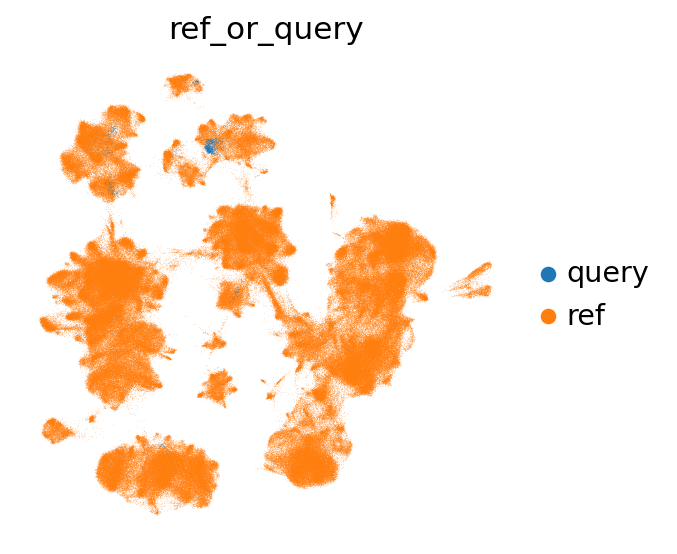

In [ ]:
sc.pl.umap(combined_emb, color="ref_or_query", frameon=False, wspace=0.6)

Now let's take a look at the label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go. Note that as we only used very few cells in the query here, they are more difficult to see in the joint embedding.

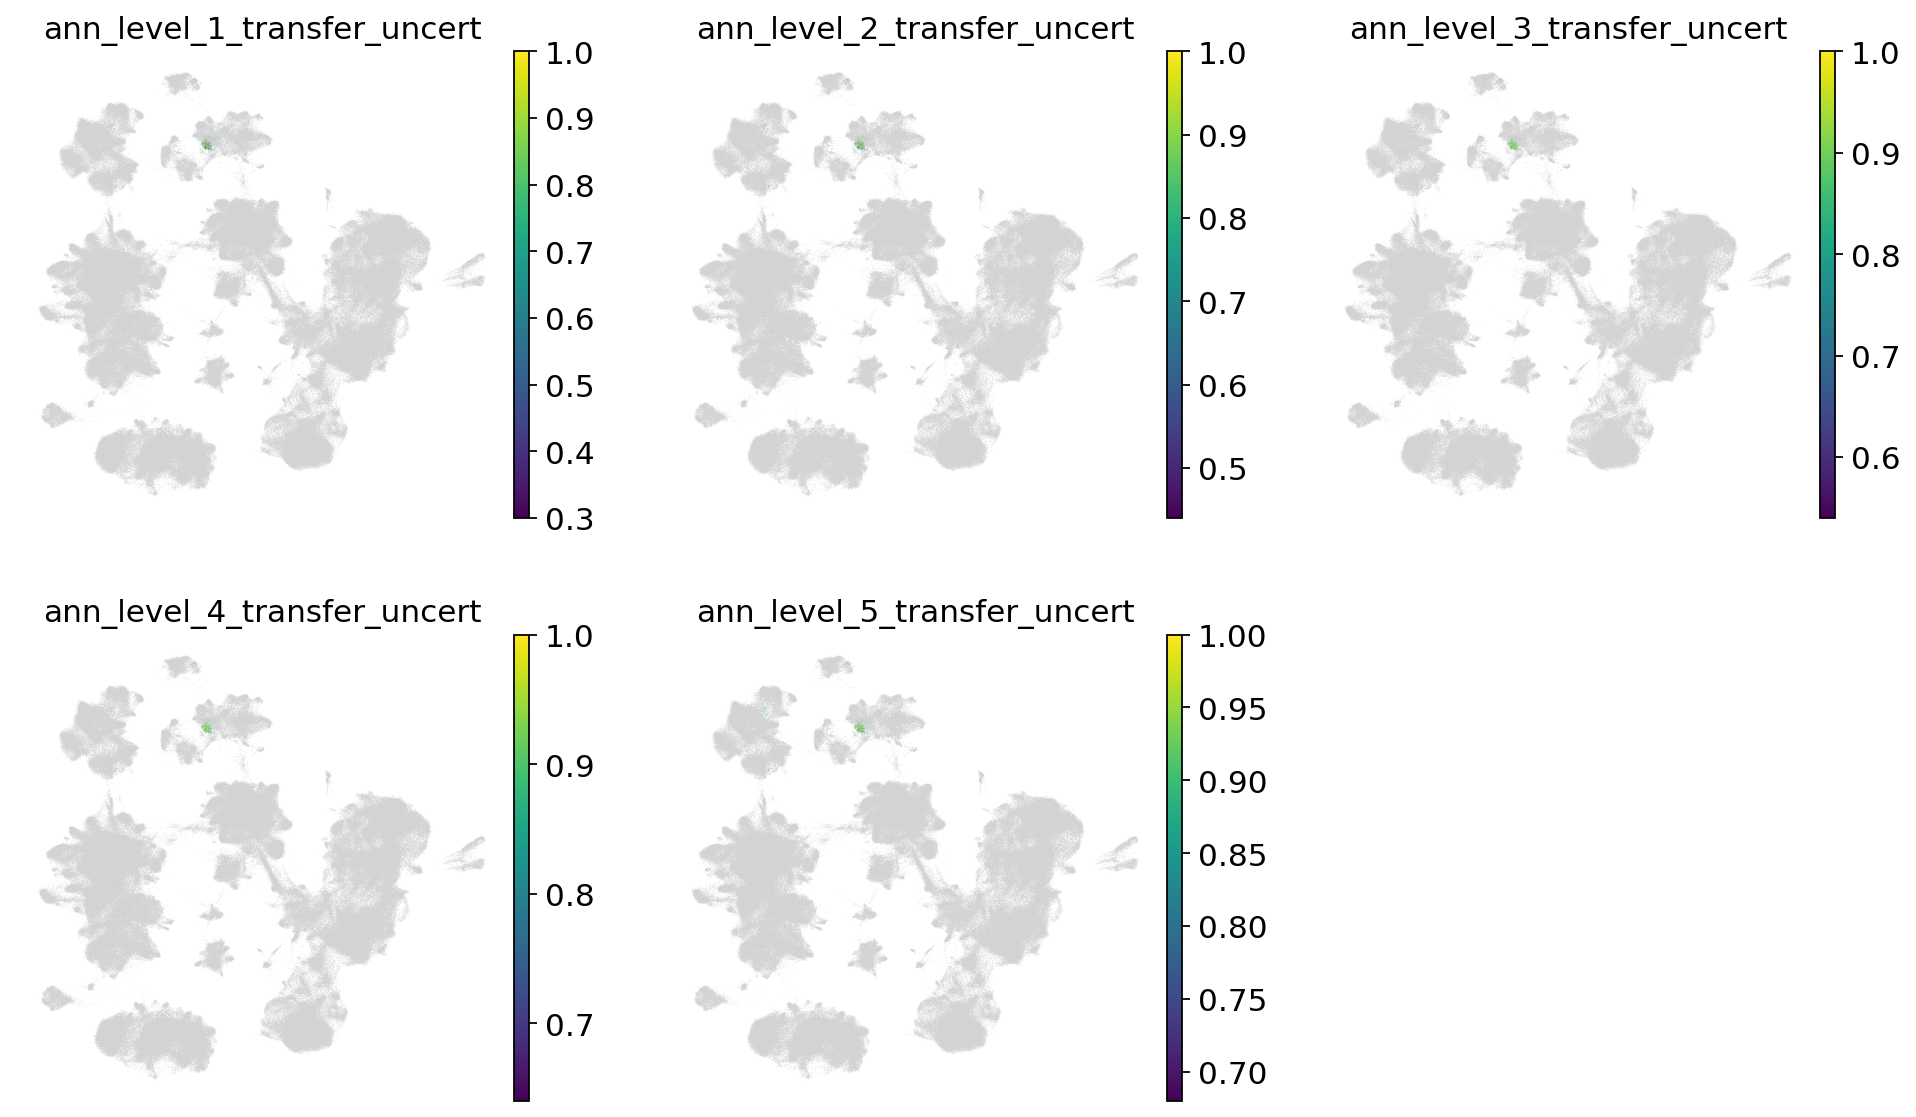

In [194]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_{lev}_transfer_uncert" for lev in range(1, 6)],
    ncols=3,
    frameon=False
)

Now let's take a look at the transferred labels, at every level. Note that the color for "Unknown" switches per plot, and that all cells from the reference are set to NA.

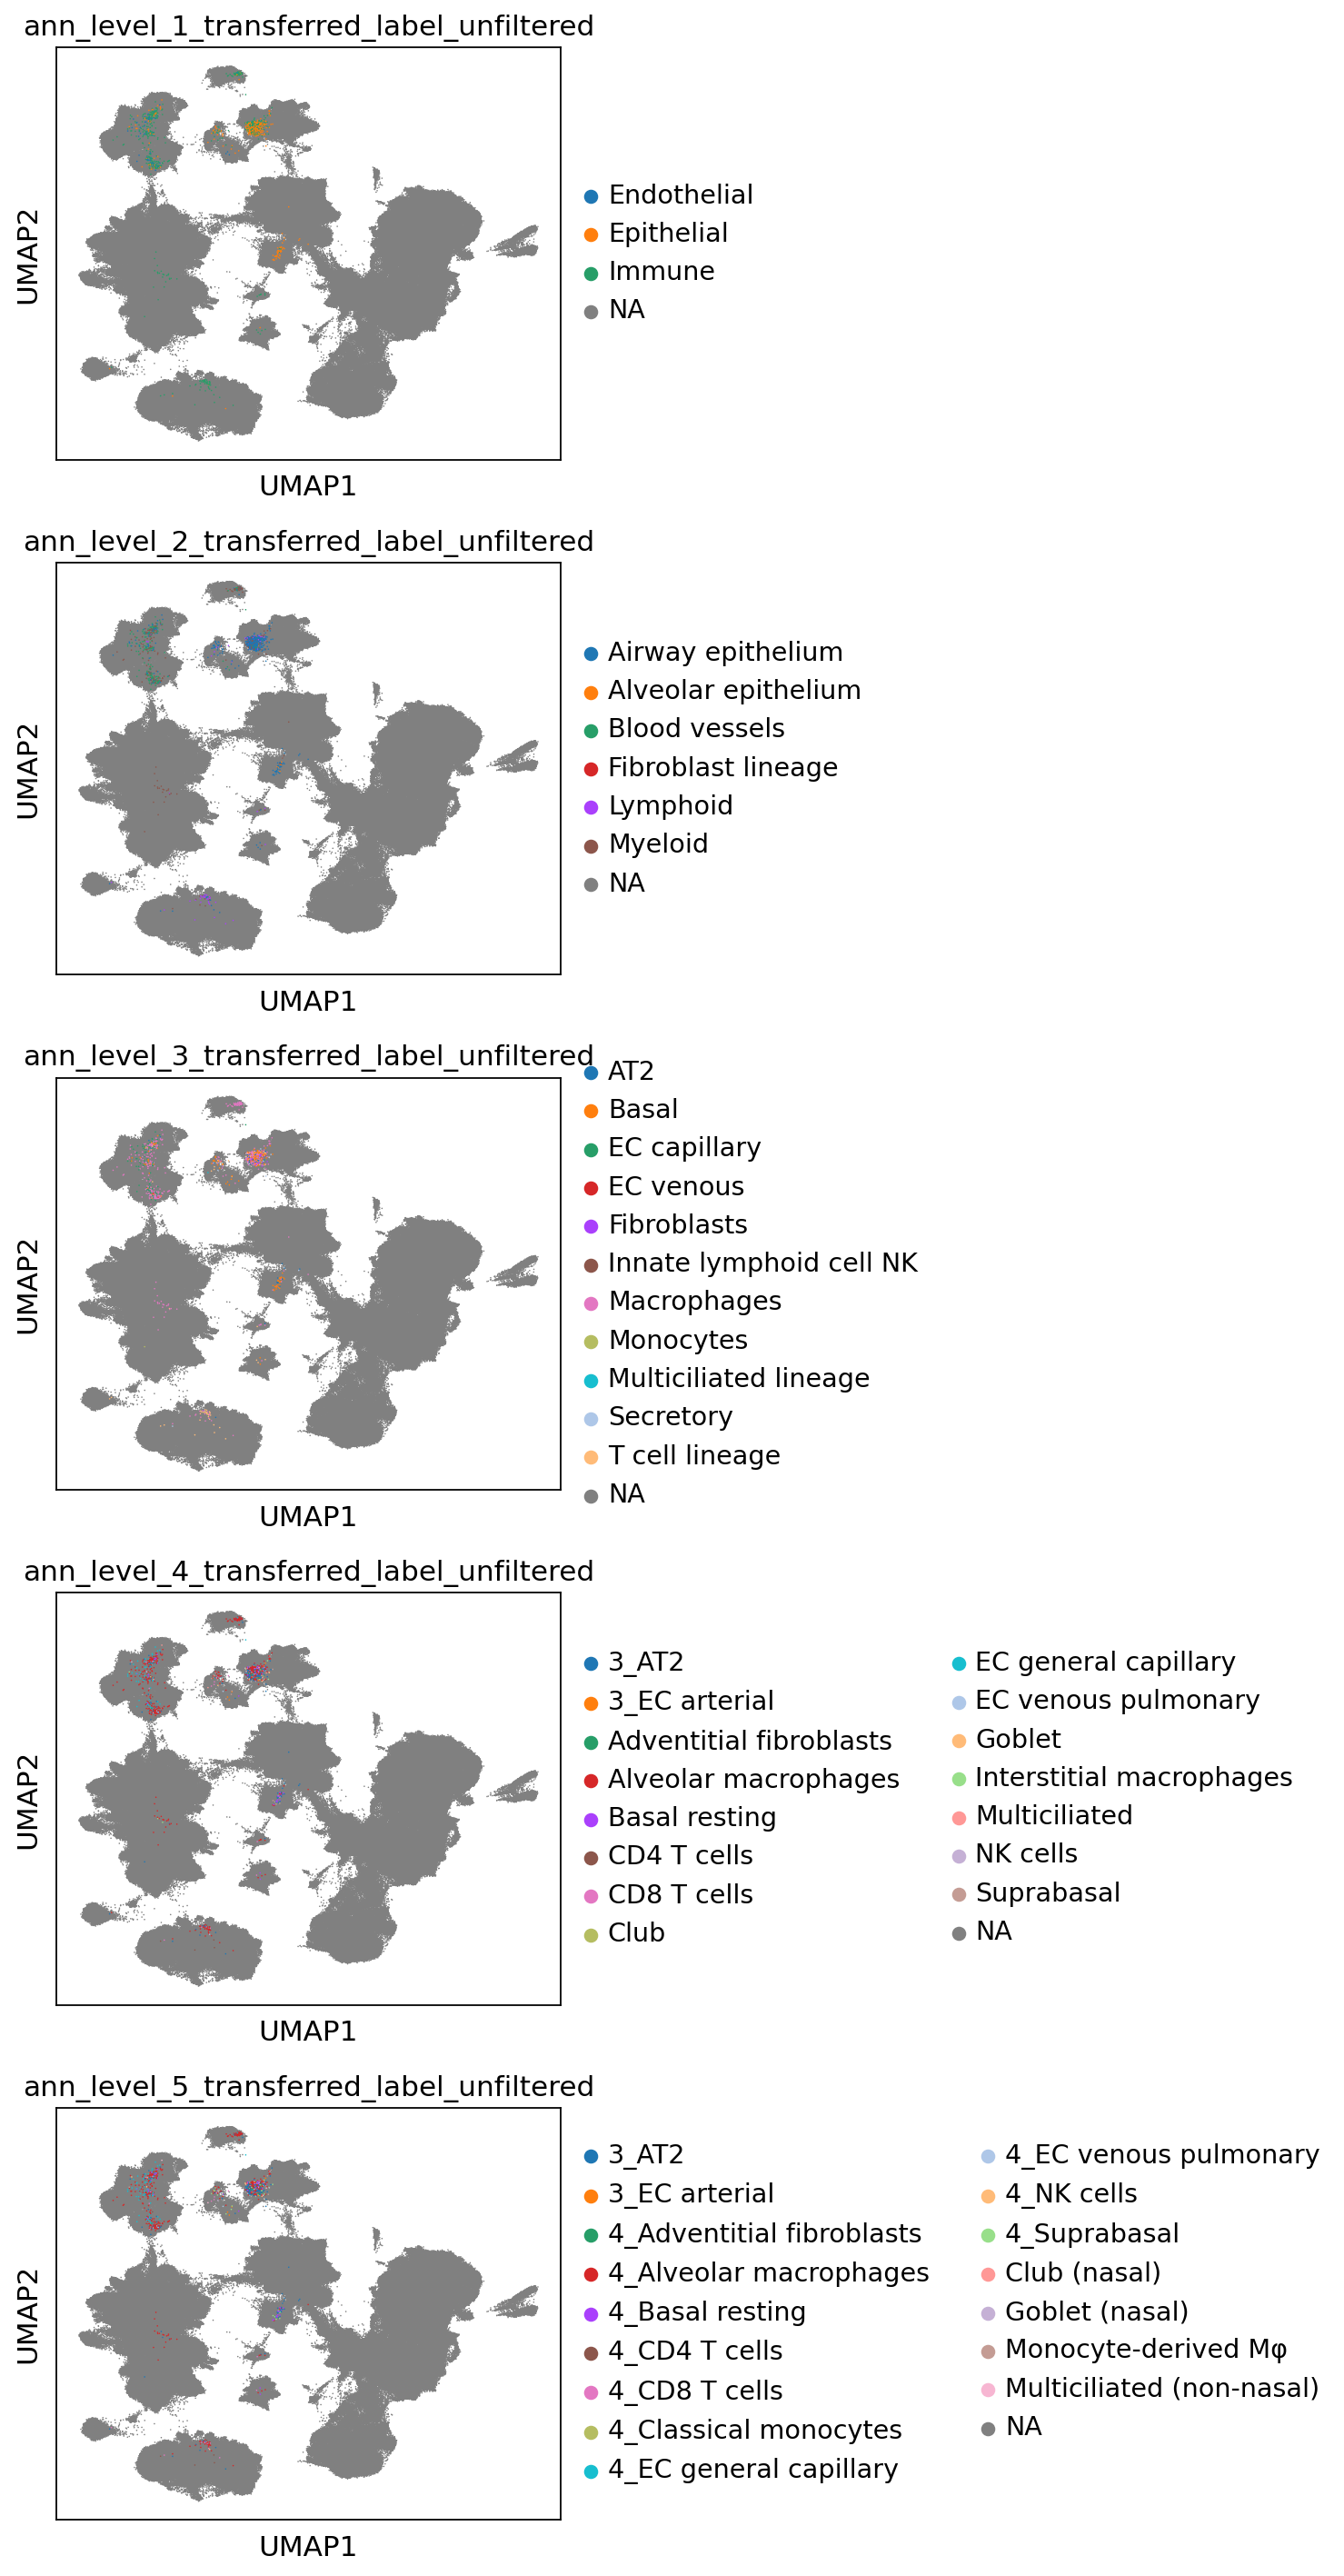

In [128]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_{lev}_transferred_label_unfiltered" for lev in range(1, 6)],
    na_color="grey",
    ncols=1,
    size=2,
)

For your reference, these are the annotations of the reference atlas:

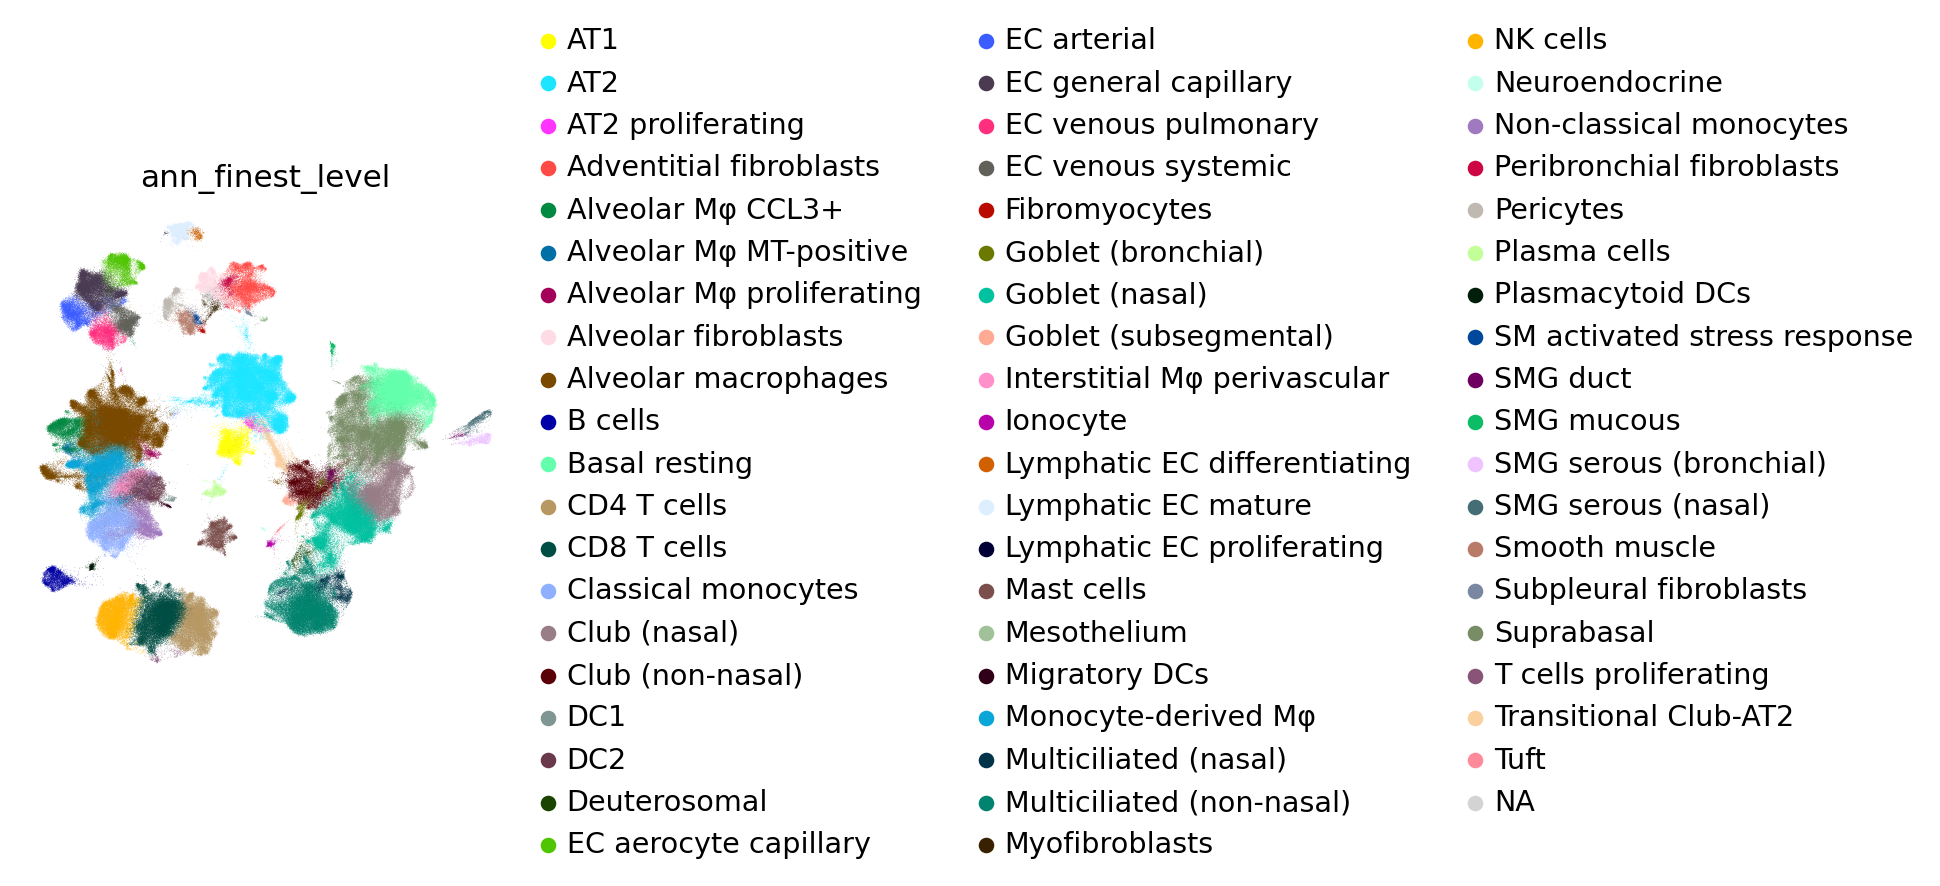

In [ ]:
sc.pl.umap(combined_emb, color="ann_finest_level", frameon=False, wspace=0.6)

In [89]:
combined_emb

AnnData object with n_obs × n_vars = 586670 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

In [90]:
for cat in ["labtransf_ann_level_1", "labtransf_ann_level_2", "labtransf_ann_level_3"]:
    combined_emb.obs.loc[adata_ref.obs.index, cat] = adata_ref.obs[cat]

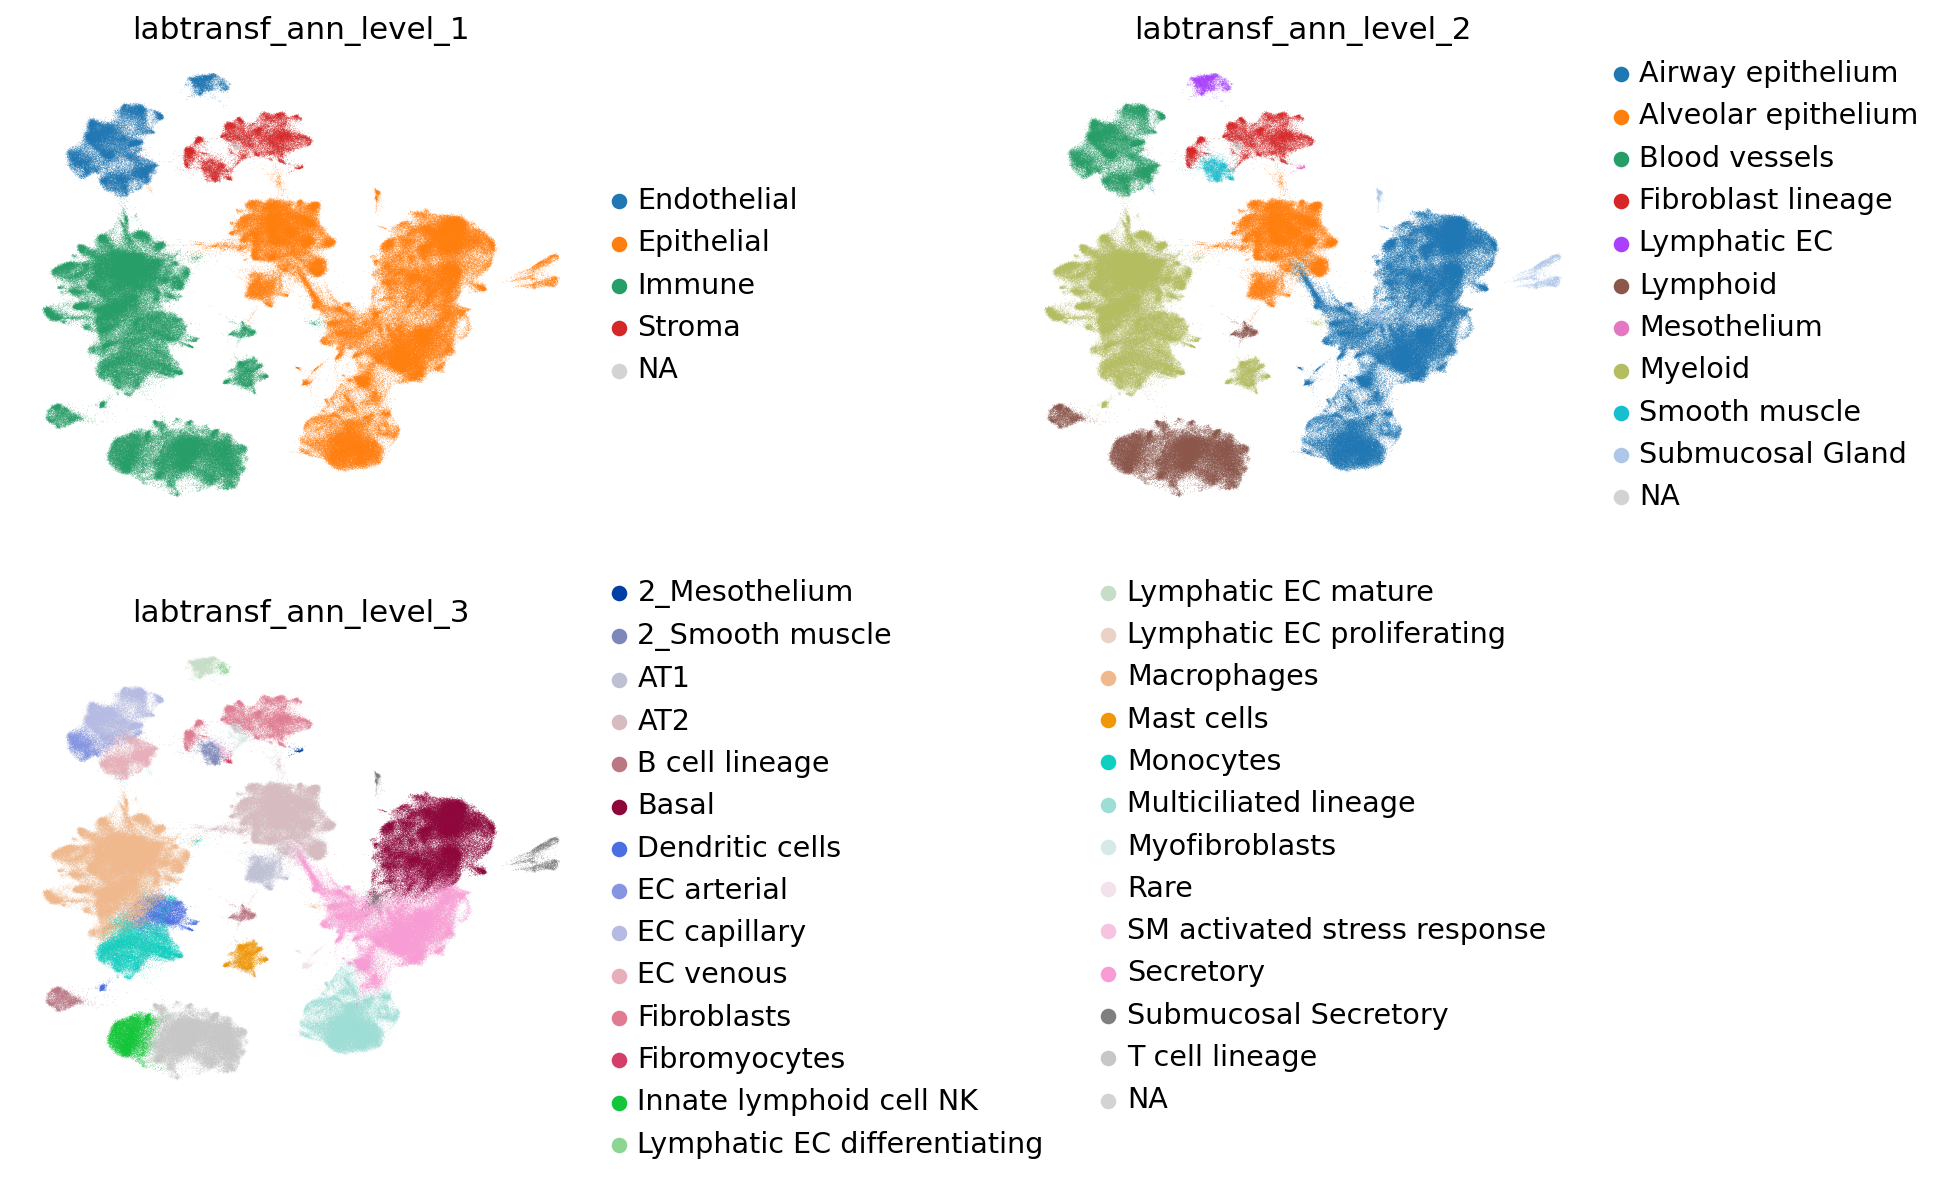

In [91]:
sc.pl.umap(
    combined_emb,
    color=["labtransf_ann_level_1", "labtransf_ann_level_2", "labtransf_ann_level_3"],
    frameon=False,
    wspace=0.6,
    ncols=2,
)

In [85]:
print("test")

test


To get a better look at the query and the uncertainty levels, we can go back to the query object (without reference), add the transfered labels and calculate the UMAP:

In [92]:
adata_query_latent.obs = combined_emb.obs.loc[adata_query_latent.obs.index, :].copy()

In [93]:
sc.pp.neighbors(adata_query_latent)
sc.tl.umap(adata_query_latent)

In [94]:
adata_query_latent

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4_c

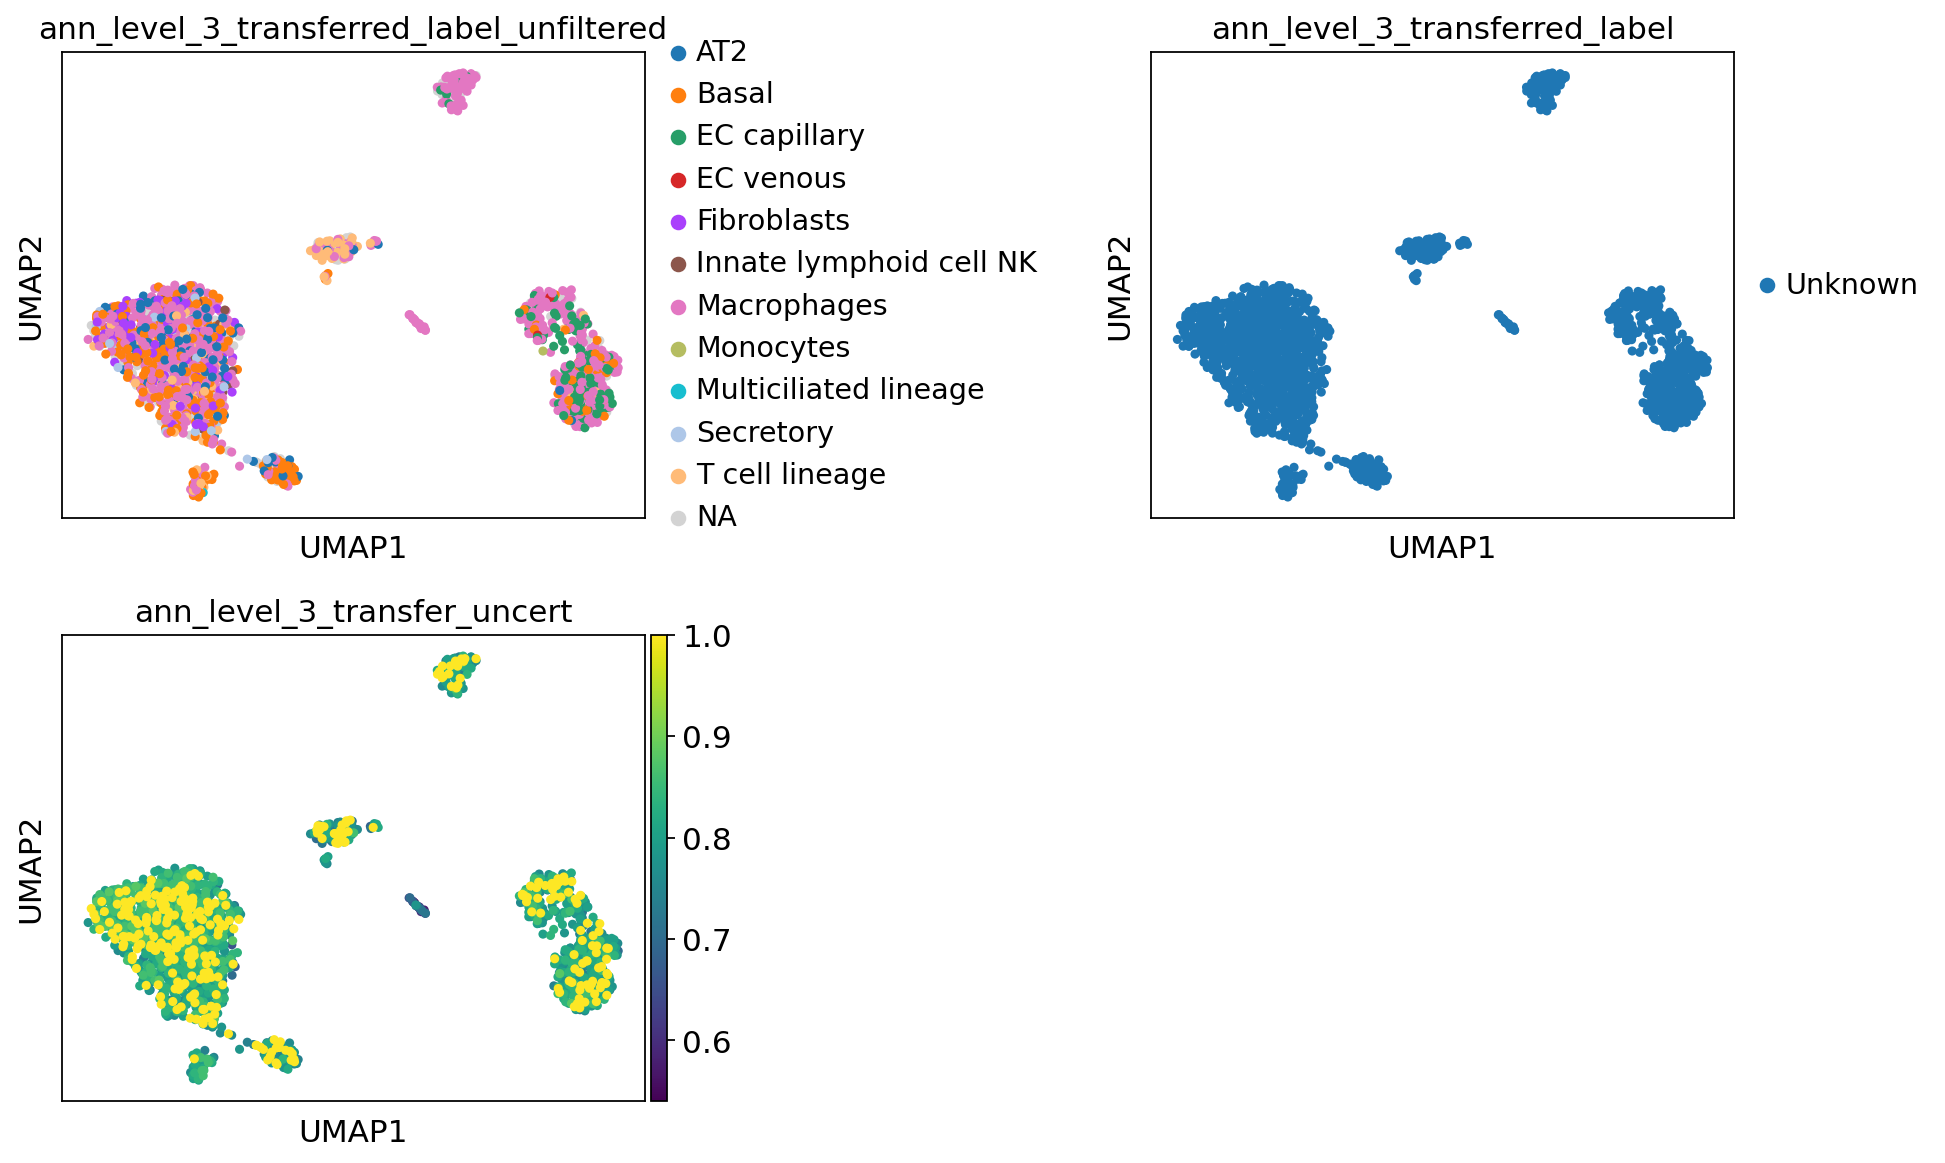

In [95]:
lev = 3
sc.pl.umap(
    adata_query_latent,
    color=[
        f"ann_level_{lev}_transferred_label_unfiltered",
        f"ann_level_{lev}_transferred_label",
        f"ann_level_{lev}_transfer_uncert",
    ],
    wspace=0.7,
    ncols=2,
)

In [99]:
adata_query_unprep.obsm["X_umap"] = adata_query_latent[
    adata_query_unprep.obs.index,
].obsm["X_umap"]

In [102]:
adata_query_unprep

AnnData object with n_obs × n_vars = 1786 × 33567
    obs: 'dataset'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_names'
    obsm: 'X_umap'

In [104]:
adata_query_unprep.var.index = adata_query_unprep.var.gene_names

In [106]:
adata_query_unprep.var

gene_ids    feature_types  \
gene_names                                                                  
MIR1302-2HG                              ENSG00000243485  Gene Expression   
FAM138A                                  ENSG00000237613  Gene Expression   
OR4F5                                    ENSG00000186092  Gene Expression   
AL627309.1                               ENSG00000238009  Gene Expression   
AL627309.3                               ENSG00000239945  Gene Expression   
...                                                  ...              ...   
SARSCoV2_SARSCoV2_ORF8            SARSCoV2_SARSCoV2_ORF8  Gene Expression   
SARSCoV2_SARSCoV2_N                  SARSCoV2_SARSCoV2_N  Gene Expression   
SARSCoV2_SARSCoV2_ORF10          SARSCoV2_SARSCoV2_ORF10  Gene Expression   
SARSCoV2_SARSCoV2_3prime        SARSCoV2_SARSCoV2_3prime  Gene Expression   
SARSCoV2_SARSCoV2_NegStrand  SARSCoV2_SARSCoV2_NegStrand  Gene Expression   

                               genome                   gene_names  
gene_names                                                          
MIR1302-2HG                    GRCh38                  MIR1302-2HG  
FAM138A                        GRCh38                      FAM138A  
OR4F5                          GRCh38                        OR4F5  
AL627309.1                     GRCh38                   AL627309.1  
AL627309.3                     GRCh38                   AL627309.3  
...                               ...                          ...  
SARSCoV2_SARSCoV2_ORF8       SARSCoV2       SARSCoV2_SARSCoV2_ORF8  
SARSCoV2_SARSCoV2_N          SARSCoV2          SARSCoV2_SARSCoV2_N  
SARSCoV2_SARSCoV2_ORF10      SARSCoV2      SARSCoV2_SARSCoV2_ORF10  
SARSCoV2_SARSCoV2_3prime     SARSCoV2     SARSCoV2_SARSCoV2_3prime  
SARSCoV2_SARSCoV2_NegStrand  SARSCoV2  SARSCoV2_SARSCoV2_NegStrand  

[33567 rows x 4 columns]

In [182]:
adata_query_unprep.obs["coi"] = "No"
adata_query_unprep.obs.loc[:, "coi"].iloc[i] = "Yes"

/tmp/ipykernel_185682/1159169702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_query_unprep.obs.loc[:, "coi"].iloc[i] = "Yes"


In [ ]:
adata_query_unprep = adata_query_unprep[adata_query_unprep.obs.index[i] + [idx for i, idx  in enuadata_query_unprep.obs.index]

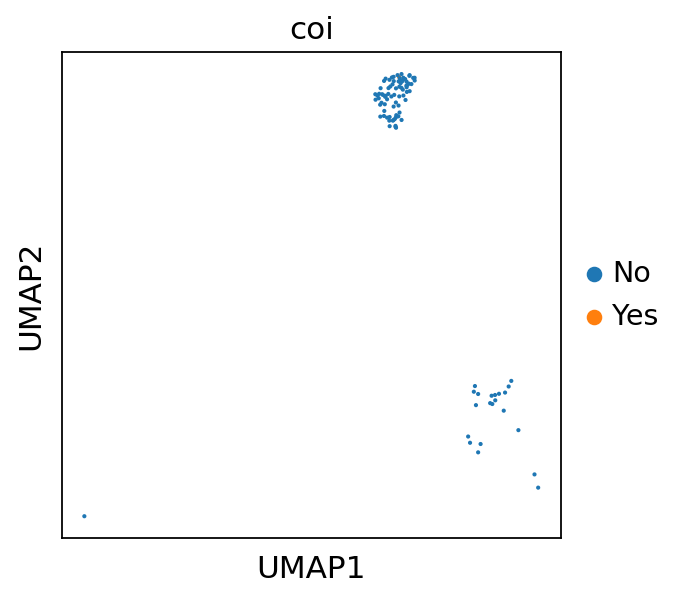

In [190]:
sc.pl.umap(
    adata_query_unprep[:100, :],
    color=["coi"],
    wspace=0.7,
    ncols=2,
    size=14,
    sort_order=True,
)

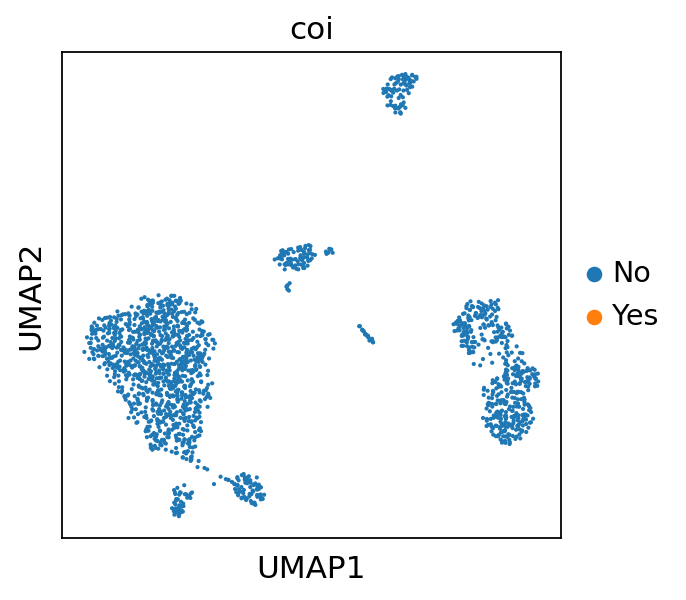

In [184]:
sc.pl.umap(
    adata_query_unprep, color=["coi"], wspace=0.7, ncols=2, size=14, sort_order=True
)

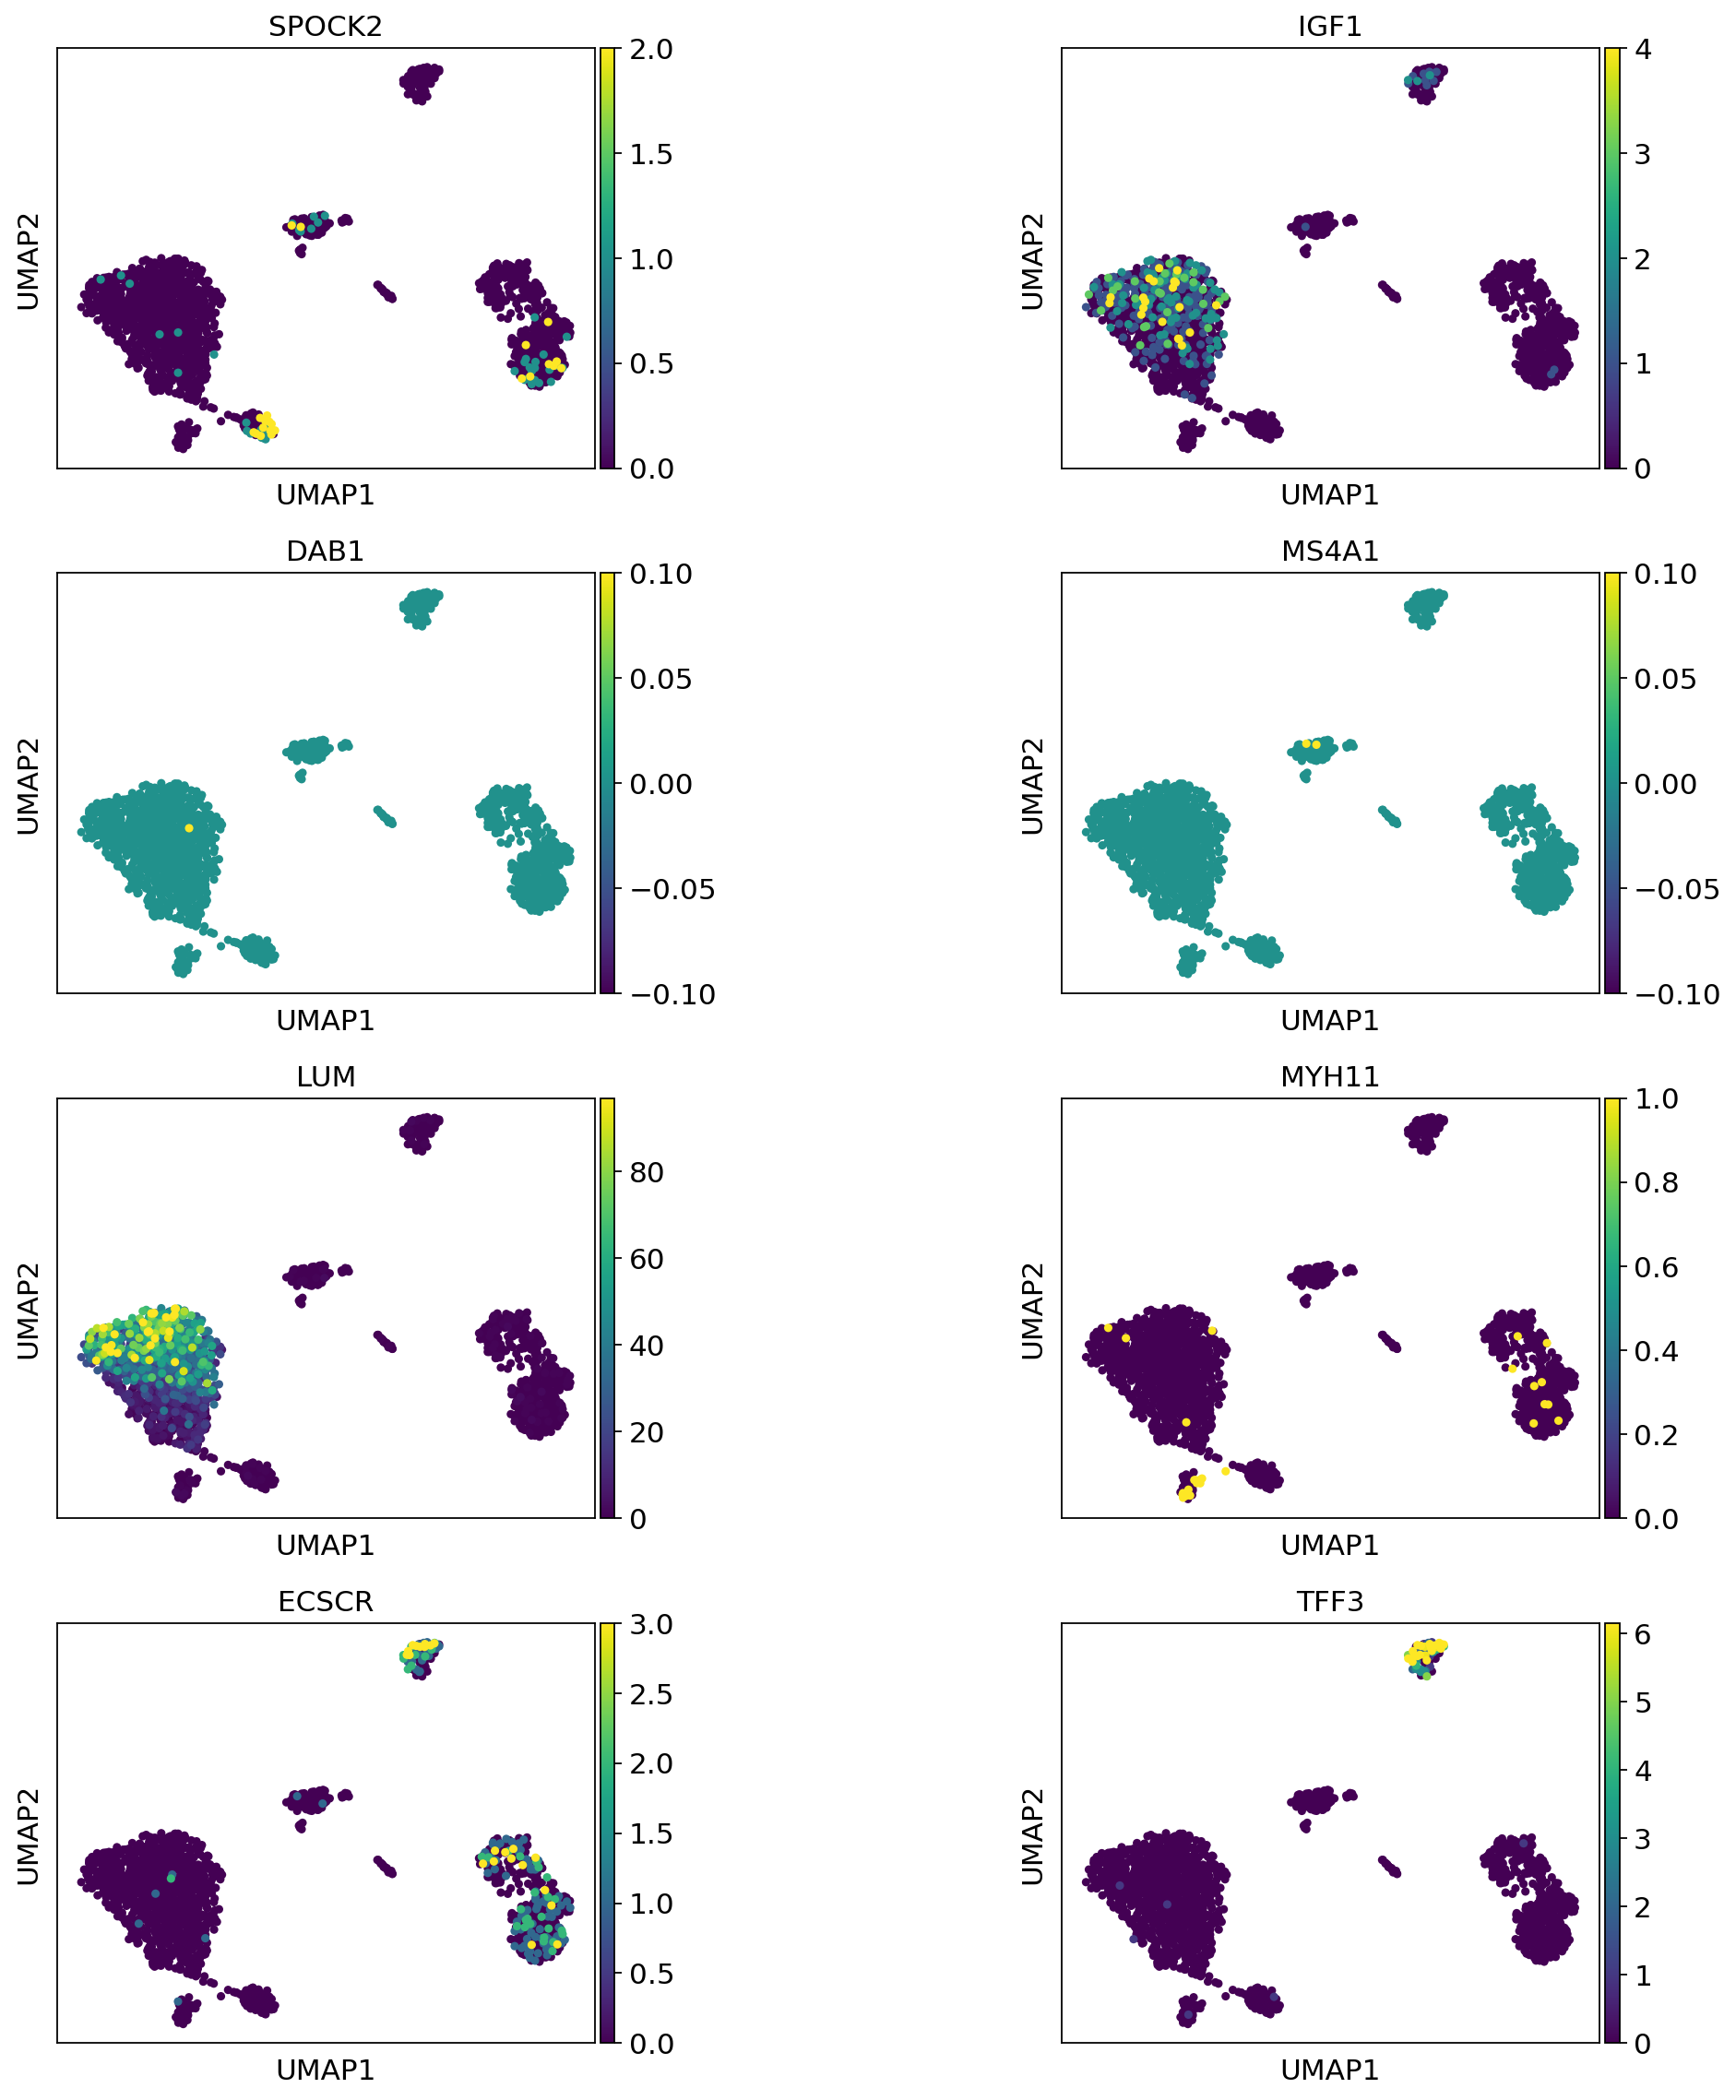

In [122]:
sc.pl.umap(
    adata_query_unprep,
    color=["SPOCK2", "IGF1", "DAB1", "MS4A1", "LUM", "MYH11", "ECSCR", "TFF3"],
    vmax="p99",
    wspace=0.7,
    ncols=2,
)

In [123]:
adata_ref

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

In [124]:
sc.pp.neighbors(adata_ref, n_neighbors=30)

In [125]:
sc.tl.umap(adata_ref)

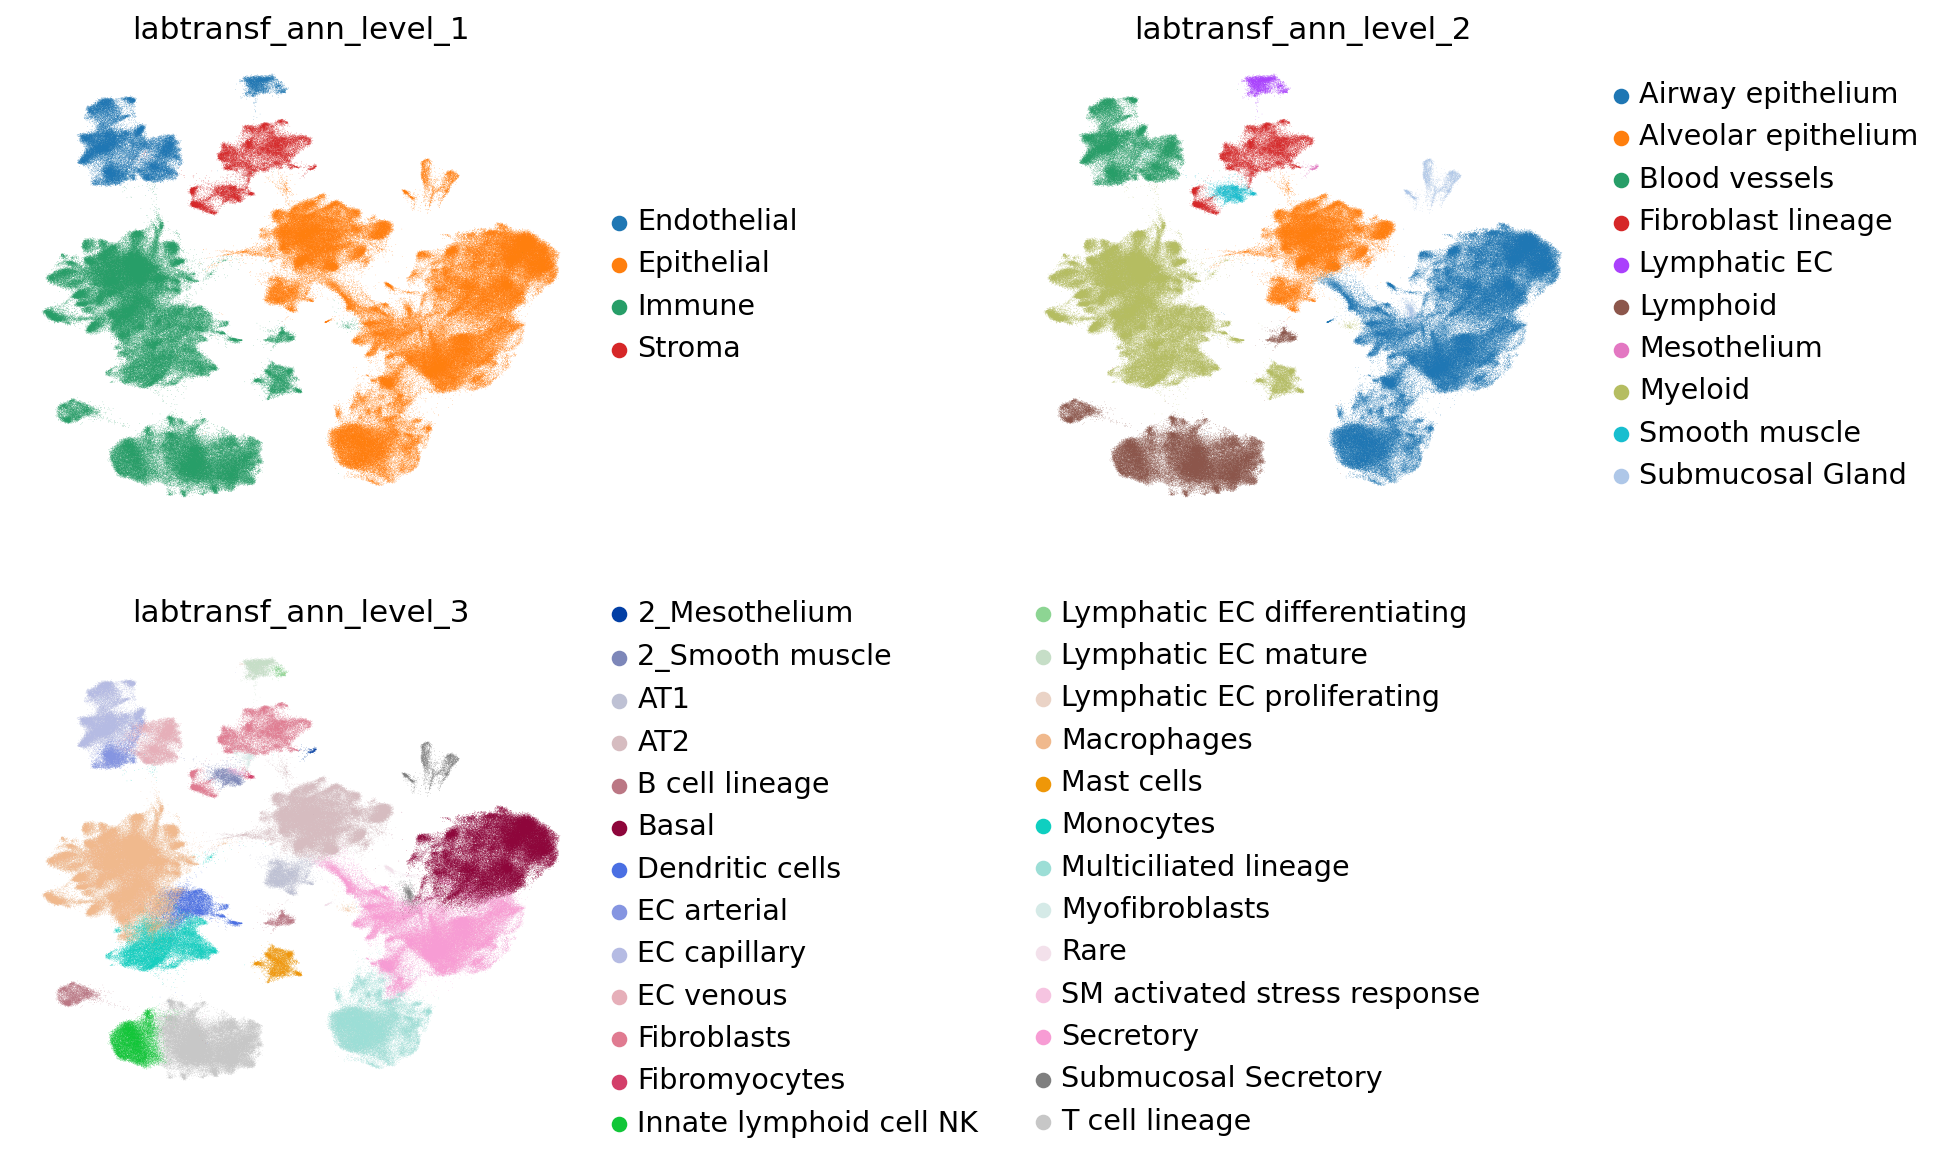

In [126]:
sc.pl.umap(
    adata_ref,
    color=["labtransf_ann_level_1", "labtransf_ann_level_2", "labtransf_ann_level_3"],
    frameon=False,
    wspace=0.6,
    ncols=2,
)

Epithelial     282065
Immune         229436
Endothelial     48166
Stroma          25217
Name: labtransf_ann_level_1, dtype: int64